In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')
import matplotlib.pyplot as plt
from scipy.signal import lfiltic, lfilter
import json
import krakenex
from pykrakenapi import KrakenAPI


In [ ]:
class FinDataStructures:
    def __init__(self):
        self.previous_sign = 0  # Initial previous sign
        self.previous_value = None  # Initial previous value
        
    def define_data(self):
        # Dollar Imabalance Bar -- we need to apply it on a dollar bar
        self.df['spread'] = self.df['ask'] - self.df['bid']
        self.df['price_delta'] =  self.df['price'].diff()
        self.df['b'] = self.df['price_delta'].apply(self.get_B_sign)
        #this can be either volume or dollar amount exchanged; depends on the sample we use (DB or VB)
        self.df['bv_VIB'] = self.df['b']*self.df['vol']
        self.df['bv_DIB'] = self.df['b']*self.df['vol']*self.df['price']
    
    def tick_bar(self, df, n):
        """ We extract price at n ticks"""
        return df[::n]

    def volume_bar(self, df, volume_tick):
        """Extracting volume bars of size v"""
        indx = []
        vol_acum = 0
        # cum_vol = 0
        for i, v in enumerate(df['vol'].values):
            vol_acum+=v
            if vol_acum>volume_tick:
                indx.append(i)
                vol_acum = 0 
        df = df.iloc[indx]
        return df

    def dollar_bar(self, df, dollar_vol_tick):
        """Extracting volume bars of size v"""
        indx = []
        mv_acum = 0
        # cum_vol = 0
        for i, mv in enumerate(df['dollar_vol'].values):
            mv_acum+=mv
            if mv_acum>dollar_vol_tick:
                indx.append(i)
                mv_acum = 0
        df = df.iloc[indx]
        return df

    def ewma_linear_filter(self, array, alpha):
        b = [alpha]
        a = [1, alpha-1]
        zi = lfiltic(b, a, array[0:1], [0])
        return lfilter(b, a, array, zi=zi)[0]

    def get_B_sign(self, x):
        if x > 0:
            result = 1
        elif x < 0:
            result = -1
        else:
            # Use the previous sign if x is 0 and there is a previous value
            result = self.previous_sign if self.previous_value is not None else 0
        
        # Update previous sign and value for the next call
        self.previous_sign = result
        self.previous_value = x
        return result
    
    def calculate_imbalance_bars(self, imbalance_value, alpha):
        Ts = []
        Bs = []
        tick_acc = 0
        imbalance = 0 

        E_T = 10000
        sell_prob = imbalance_value.mean()
        expected_tick_imbalance = E_T * np.abs(sell_prob)

        for tick, b in enumerate(imbalance_value.values):
            tick_acc += tick
            imbalance += b
            if abs(imbalance) > expected_tick_imbalance:
                # if we decide to sample, we get a bar
                Ts.append(tick)
                Bs.append(b)

                E_T = self.ewma_linear_filter(Ts, alpha)[-1]
                sell_prob = self.ewma_linear_filter(Bs, alpha)[-1]

                expected_tick_imbalance = E_T * np.abs(sell_prob)

                tick_acc = 0
                imbalance = 0
        return df.iloc[Ts]

In [92]:
df = pd.read_parquet("../src/data/IVE_tickbidask.parquet")
#(a) Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.
df_minute = df.price.resample('min').ohlc().dropna()

In [93]:
finstructs = FinDataStructures()
finstructs.df = df
finstructs.define_data()
finstructs.tick_data = finstructs.tick_bar(finstructs.df, n=1000)
finstructs.volme_data = finstructs.volume_bar(finstructs.df, volume_tick=1_000)
finstructs.dollar_data = finstructs.dollar_bar(finstructs.df, dollar_vol_tick=100_000)

In [56]:
volume_imbalance_bar = finstructs.calculate_imbalance_bars(df.bv_VIB, alpha=0.9)

In [48]:
finstructs.calculate_imbalance_bars(df.bv_VIB)

,price,bid,ask,vol,dollar_vol,spread,price_delta,b,bv_VIB,bv_DIB
date,,,,,,,,,,
2009-09-28 11:54:14,51.4170,51.41,51.42,1640,8.432388e+04,0.01,0.0070,1,1640,8.432388e+04
2009-12-29 13:14:59,53.5491,53.53,53.55,100,5.354910e+03,0.02,0.0003,1,100,5.354910e+03
2020-02-21 16:04:57,130.5841,130.48,130.97,2000000,2.611682e+08,0.49,-0.0459,-1,-2000000,-2.611682e+08


In [62]:
finstructs.calculate_imbalance_bars(df.b, alpha=0.5)

,price,bid,ask,vol,dollar_vol,spread,price_delta,b,bv_VIB,bv_DIB
date,,,,,,,,,,
2009-09-28 09:48:06,51.12,51.11,51.13,100,5112.0,0.02,0.0,1,100,5112.0
2009-09-28 11:52:17,51.43,51.41,51.43,300,15429.0,0.02,0.0,1,300,15429.0
2009-11-03 11:26:13,49.42,49.40,49.42,600,29652.0,0.02,0.0,1,600,29652.0


In [65]:
finstructs.calculate_imbalance_bars(df.bv_DIB, alpha=0.5)

,price,bid,ask,vol,dollar_vol,spread,price_delta,b,bv_VIB,bv_DIB
date,,,,,,,,,,
2009-10-13 09:34:41,52.016,51.99,52.02,2800,1.456448e+05,0.03,0.0061,1,2800,1.456448e+05
2018-12-21 16:18:54,97.928,96.05,99.37,558061,5.464980e+07,3.32,-0.0020,-1,-558061,-5.464980e+07


In [69]:
df['cumsum_b'] = df['b'].cumsum()
df['cumsum_vib'] = df['bv_VIB'].cumsum()

In [70]:
finstructs.calculate_imbalance_bars(df.bv_VIB, alpha=0.5)

,price,bid,ask,vol,dollar_vol,spread,price_delta,b,bv_VIB,bv_DIB,cumsum_b,cumsum_vib
date,,,,,,,,,,,,
2009-09-28 11:54:14,51.4170,51.41,51.42,1640,8.432388e+04,0.01,0.0070,1,1640,8.432388e+04,122,83705
2009-12-29 13:14:59,53.5491,53.53,53.55,100,5.354910e+03,0.02,0.0003,1,100,5.354910e+03,1003,1077638
2020-02-21 16:04:57,130.5841,130.48,130.97,2000000,2.611682e+08,0.49,-0.0459,-1,-2000000,-2.611682e+08,-6584,-17860605


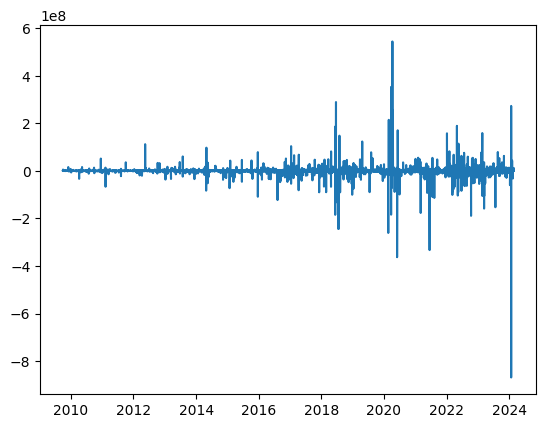

In [60]:
plt.plot(df.bv_DIB)

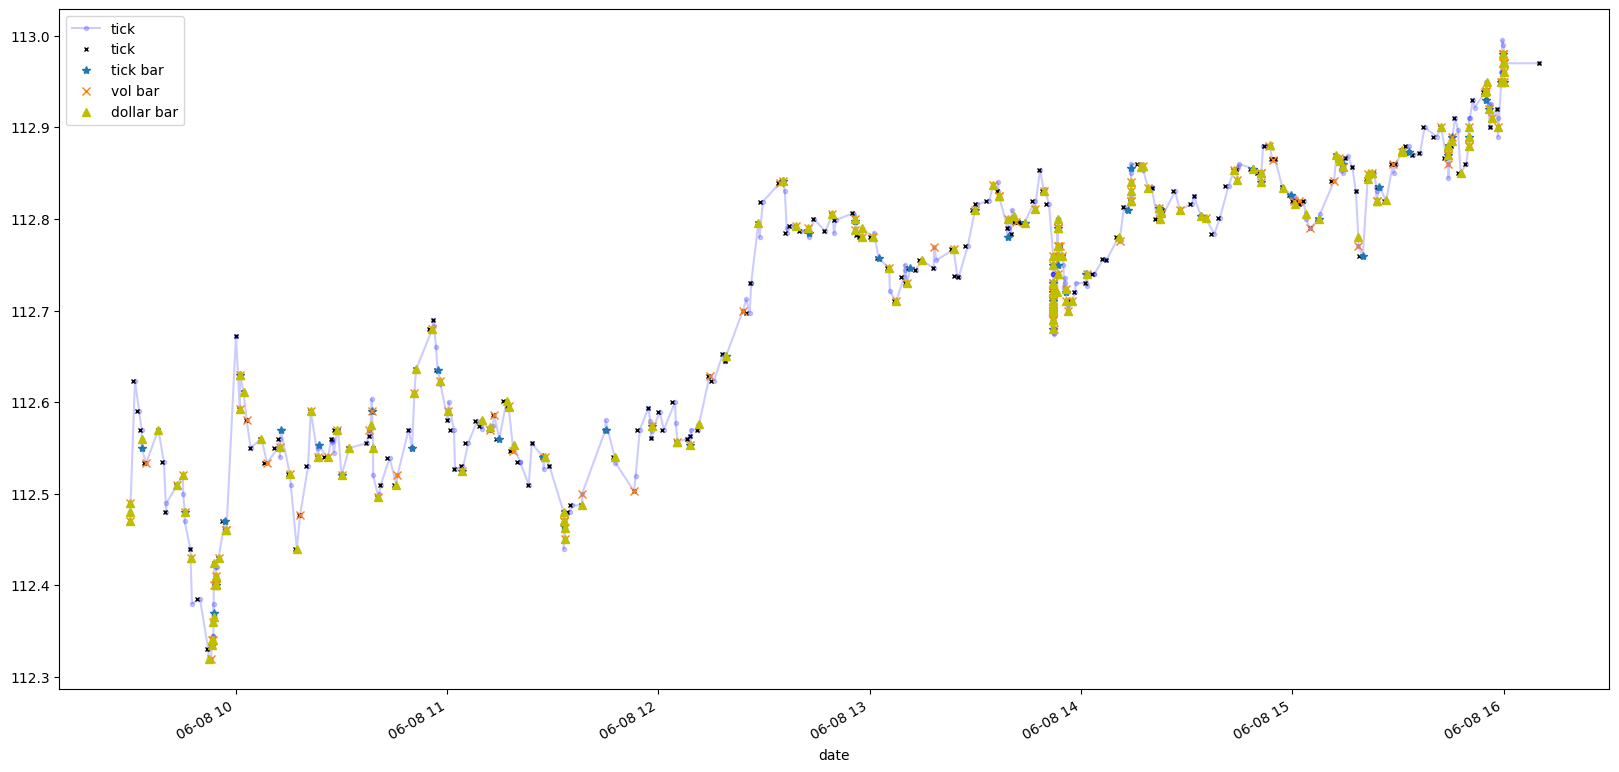

In [51]:
s_date='2018-06-08 8:00:00'
e_date='2018-06-08 17:00:00'
plt.figure(figsize=(20,10))
df.loc[s_date:e_date].price.plot(marker='o',
                                 ms=3,
                                 color='b',
                                 alpha=0.2,
                                 label='tick')

df_minute.open.loc[s_date:e_date].plot(marker='x',
                                       ms=3,
                                       ls='',
                                       color='k',
                                       label='tick')
df_tick.loc[s_date:e_date].price.plot(marker='*',
                                      ls='',
                                      label='tick bar')
df_vol.loc[s_date:e_date].price.plot(marker='x',
                                     ls='',
                                     label='vol bar')
df_dollar.loc[s_date:e_date].price.plot(marker='^',
                                        ls='',
                                        color='y',
                                        label='dollar bar')
plt.legend()

### Question 1b
Count the number of bars produced by tick, volume, and dollar bars on a
weekly basis. Plot a time series of that bar count. What bar type produces
the most stable weekly count? Why?m

In [52]:
weekly_tick_count = df_tick.price.resample('1W').count()
weekly_volume_count = df_vol.price.resample('1W').count()
weekly_dollar_count = df_dollar.price.resample('1W').count()

In [67]:
weekly_tick_count.mean(),weekly_tick_count.std(), weekly_tick_count.mean()/weekly_tick_count.std()

(358.48670212765956, 236.6204348370017, 1.5150284985935665)

In [68]:
weekly_volume_count.mean(),weekly_volume_count.std(), weekly_volume_count.mean()/weekly_volume_count.std()

(926.8537234042553, 531.5316334671571, 1.7437414164015599)

In [69]:
weekly_dollar_count.mean(),weekly_dollar_count.std(), weekly_dollar_count.mean()/weekly_dollar_count.std()

(951.7114361702128, 609.7349497093, 1.5608608898406675)

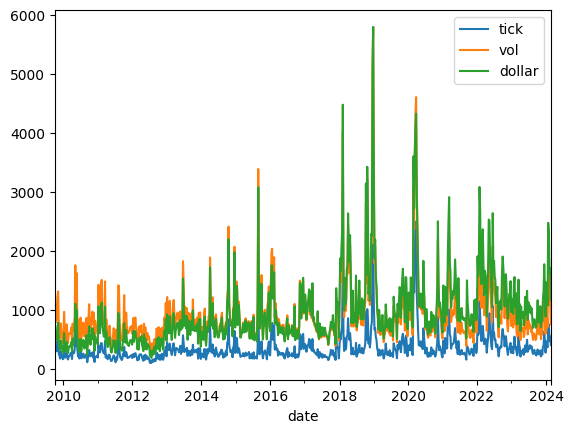

In [56]:
fig, ax = plt.subplots(1)
weekly_tick_count.plot(ax=ax)
weekly_volume_count.plot(ax=ax)
weekly_dollar_count.plot(ax=ax)
ax.legend(["tick", "vol", 'dollar'])

In [ ]:
weekly_tick_count.max()

In [63]:
def scale_ticks(x):
    return (x-x.min())/(x.max()- x.min())

In [65]:
weekly_tick_count_scaled = scale_ticks(weekly_tick_count)
weekly_volume_count_scaled = scale_ticks(weekly_volume_count)
weekly_dollar_count_scaled = scale_ticks(weekly_dollar_count)

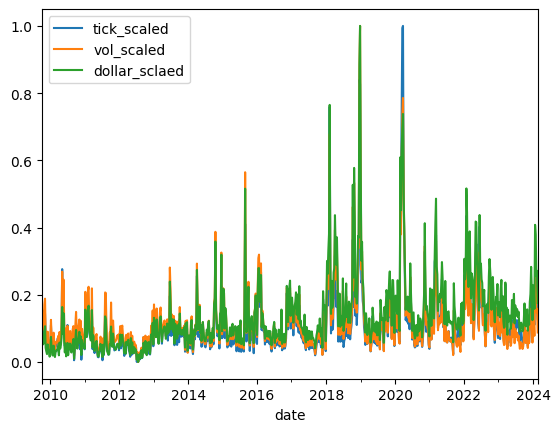

In [66]:
fig, ax = plt.subplots(1)
weekly_tick_count_scaled.plot(ax=ax)
weekly_volume_count_scaled.plot(ax=ax)
weekly_dollar_count_scaled.plot(ax=ax)
ax.legend(["tick_scaled", "vol_scaled", 'dollar_sclaed'])

#### Question 1c 
Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

In [72]:
df_tick['price'].autocorr()

0.9999767855512354

In [75]:
df_tick

,price,bid,ask,vol,dollar_vol,spread
date,,,,,,
2009-09-28 09:30:00,50.7900,50.70,50.79,100,5079.0000,0.09
2009-09-28 09:33:02,50.8100,50.80,50.81,500,25405.0000,0.01
2009-09-28 09:37:22,50.8340,50.83,50.85,200,10166.8000,0.02
2009-09-28 09:40:20,50.7980,50.77,50.80,122,6197.3560,0.03
2009-09-28 09:44:09,50.9100,50.91,50.92,1100,56001.0000,0.01
...,...,...,...,...,...,...
2024-02-23 15:53:31,179.8500,179.85,179.86,200,35970.0000,0.01
2024-02-23 15:55:00,179.7900,179.78,179.80,300,53937.0000,0.02
2024-02-23 15:55:25,179.8100,179.81,179.81,100,17981.0000,0.00


In [85]:
import numpy as np

In [136]:
tick_returns = np.log(df_tick['price']).diff().dropna()
vol_returns = np.log(df_vol['price']).diff().dropna()
dollar_returns = np.log(df_dollar['price']).diff().dropna()

In [137]:
tick_returns.autocorr()

-0.49407560046607346

In [138]:
vol_returns.autocorr()

-0.21349544711051247

In [139]:
dollar_returns.autocorr()

0.05034043588779888

### Question 1d
Partition the bar series into monthly subsets. Compute the variance of returns for every subset of every bar type. Compute the variance of those variances. What method exhibits the smallest variance of variances?

In [140]:
def calculate_variance_of_variance(series, sample_period):
    return series.resample(sample_period).var().var()

In [141]:
calculate_variance_of_variance(tick_returns, '1M')

1.1776147854981803e-05

In [142]:
calculate_variance_of_variance(vol_returns, '1M')

5.082933447876021e-07

In [143]:
calculate_variance_of_variance(dollar_returns, '1M')

4.3324512379734637e-11

#### 1d (e) Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?

JB = (n/6) * (S**2 + .25*(K-3)**2) <br>
where S is skewness and K is kurtosis 


In [146]:
tick_returns.skew()

-13.048475333169941

In [147]:
tick_returns.kurt()

77627.7518098094

In [148]:
def calculate_JB(series):
    n = len(series)
    S = series.skew()
    K = series.kurt()
    JB = (n/6) * (S**2 + .25*(K-3)**2)
    return JB

In [149]:
jb_value_tick = calculate_JB(tick_returns)
jb_value_tick = calculate_JB(tick_returns)
jb_value_tick = calculate_JB(tick_returns)

67682834232312.12

In [150]:
from scipy.stats import jarque_bera

In [151]:
jb_value_tick, _ = jarque_bera(tick_returns)

### Future tick data
On a series of E-mini S&P 500 futures tick data, compute dollar bars and dollar imbalance bars. What bar type exhibits greater serial correlation? Why?

### Bollinger bands
Compute Bollinger bands of width 5% around a rolling moving average. Count how many times prices cross the bands out (from within the bands to outside the bands).

In [95]:
dollar_bars = finstructs.dollar_data

In [102]:
moving_avg = dollar_bars['price'].rolling(10).mean()
moving_std = dollar_bars['price'].rolling(10).std()

In [105]:
upper_band = moving_avg + moving_std * 2
lower_band = moving_avg - moving_std * 2

<Axes: xlabel='date'>

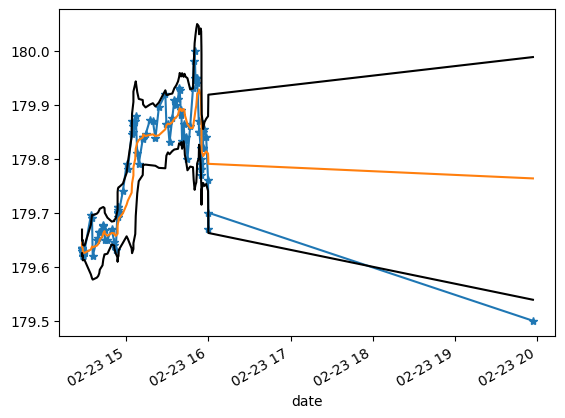

In [108]:
fig, ax = plt.subplots(1)
dollar_bars.iloc[-100:].price.plot(ax=ax, marker='*')
moving_avg.iloc[-100:].plot(ax=ax)
upper_band.iloc[-100:].plot(ax=ax, color='k')
lower_band.iloc[-100:].plot(ax=ax, color='k')

In [106]:
dollar_bars = dollar_bars.dropna()

In [101]:
dollar_bars.rolling_price.std

<bound method NDFrame._add_numeric_operations.<locals>.std of date
2009-09-28 09:44:09     50.83598
2009-09-28 09:45:02     50.88398
2009-09-28 09:46:34     50.93198
2009-09-28 09:46:34     50.98000
2009-09-28 09:46:35     51.02600
                         ...    
2024-02-23 15:58:26    179.83700
2024-02-23 15:59:48    179.82498
2024-02-23 15:59:59    179.79498
2024-02-23 16:00:00    179.76498
2024-02-23 19:57:01    179.69398
Name: rolling_price, Length: 715683, dtype: float64>